In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygsp
import mplleaflet


March 1st: first reported case in New York 
<br>
March 4th: Yeshiva University campus closed, high school in the Bronx 
<br>
March 9th 16 confirmed cases 
<br>
March 10th: mitigation measures expanded (online classes for universities) 
<br>
March 11th: CUNY and SUNY closed
<br>
March 14th: first reported death in New York 
<br>
March 16th: NYC public schools closed 
<br>
March 20th: stay-at-home order for non-essential workers, total over 7000 cases
<br>
March 22nd: shortages of PPE for health workers, recommendation that health facilities stop testing non-hospitalized patients
<br>
March 26th: USNS Comfort heading to NYC to assist local hospitals 


New York Weather : MARCH

[weather data](https://www.timeanddate.com/weather/usa/new-york/historic?month=3&year=2020)

In [2]:
df = pd.read_csv('./data/202003-citibike-tripdata.csv')
n_start_station = len(df['start station id'].unique())
n_end_station = len(df['end station id'].unique())


In [3]:
total_station_id = set(df['start station id']).union(set(df['end station id']))
n_tot_station = len(total_station_id)

In [4]:
id_index = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [5]:
df.head()

tripduration                 starttime                  stoptime  \
0          1589  2020-03-01 00:00:03.6400  2020-03-01 00:26:32.9860   
1           389  2020-03-01 00:00:16.7560  2020-03-01 00:06:46.0620   
2           614  2020-03-01 00:00:20.0580  2020-03-01 00:10:34.2200   
3           597  2020-03-01 00:00:24.3510  2020-03-01 00:10:22.3390   
4          1920  2020-03-01 00:00:26.1120  2020-03-01 00:32:26.2680   

   start station id        start station name  start station latitude  \
0               224     Spruce St & Nassau St               40.711464   
1               293     Lafayette St & E 8 St               40.730207   
2               379           W 31 St & 7 Ave               40.749156   
3              3739  Perry St & Greenwich Ave               40.735918   
4               236       St Marks Pl & 2 Ave               40.728419   

   start station longitude  end station id             end station name  \
0               -74.005524            3574  Prospect Pl & Underhill Ave   
1               -73.991026             223              W 13 St & 7 Ave   
2               -73.991600             515             W 43 St & 10 Ave   
3               -74.000939             325              E 19 St & 3 Ave   
4               -73.987140            3124                46 Ave & 5 St   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.676969             -73.965790   16214  Subscriber   
1             40.737815             -73.999947   29994  Subscriber   
2             40.760094             -73.994618   39853  Subscriber   
3             40.736245             -73.984738   42608  Subscriber   
4             40.747310             -73.954510   36288  Subscriber   

   birth year  gender  
0        1980       1  
1        1991       2  
2        1991       1  
3        1989       1  
4        1993       1

# Location Parser #

In [6]:
useful = [3, 5, 6, 7, 9, 10]
df.iloc[:,useful]

start station id  start station latitude  start station longitude  \
0                     224               40.711464               -74.005524   
1                     293               40.730207               -73.991026   
2                     379               40.749156               -73.991600   
3                    3739               40.735918               -74.000939   
4                     236               40.728419               -73.987140   
...                   ...                     ...                      ...   
1068452               422               40.770513               -73.988038   
1068453               523               40.754666               -73.991382   
1068454               528               40.742909               -73.977061   
1068455              3043               40.681460               -73.934903   
1068456              3721               40.767549               -73.920933   

         end station id  end station latitude  end station longitude  
0                  3574             40.676969             -73.965790  
1                   223             40.737815             -73.999947  
2                   515             40.760094             -73.994618  
3                   325             40.736245             -73.984738  
4                  3124             40.747310             -73.954510  
...                 ...                   ...                    ...  
1068452            3356             40.774667             -73.984706  
1068453             442             40.746647             -73.993915  
1068454             487             40.733143             -73.975739  
1068455            3755             40.690648             -73.957462  
1068456            3592             40.763359             -73.928647  

[1068457 rows x 6 columns]

# Find Locations #

In [7]:
locations = dict()
for e in id_index.keys():
    if df[df['start station id'] == e]['start station latitude'].shape[0]:
        locations[id_index[e]] = (df[df['start station id'] == e]['start station longitude'].iloc[0],
                                  df[df['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations[id_index[e]] = (df[df['end station id'] == e]['end station longitude'].iloc[0],
                                  df[df['end station id'] == e]['end station latitude'].iloc[0])
 

# Parser #

In [8]:
useful = [1, 0, 3, 7, 11, 13, 14]
df.iloc[:,useful]

starttime  tripduration  start station id  \
0        2020-03-01 00:00:03.6400          1589               224   
1        2020-03-01 00:00:16.7560           389               293   
2        2020-03-01 00:00:20.0580           614               379   
3        2020-03-01 00:00:24.3510           597              3739   
4        2020-03-01 00:00:26.1120          1920               236   
...                           ...           ...               ...   
1068452  2020-03-31 23:56:06.0490           137               422   
1068453  2020-03-31 23:57:27.6850          1548               523   
1068454  2020-03-31 23:58:00.2690           308               528   
1068455  2020-03-31 23:58:42.9010           872              3043   
1068456  2020-03-31 23:59:17.2580           306              3721   

         end station id  bikeid  birth year  gender  
0                  3574   16214        1980       1  
1                   223   29994        1991       2  
2                   515   39853        1991       1  
3                   325   42608        1989       1  
4                  3124   36288        1993       1  
...                 ...     ...         ...     ...  
1068452            3356   18851        1989       2  
1068453             442   36539        1993       1  
1068454             487   43023        1982       1  
1068455            3755   43073        1990       1  
1068456            3592   39373        1974       1  

[1068457 rows x 7 columns]

# Util Functions #

In [9]:
# Find indexes to extract daily rides

def days_index():
    d_i = {}
    for index, row in df.iterrows():
        day = int(row['starttime'].split()[0].split('-')[2])
        if d_i.get(day) is None:
            d_i[day] = index
    return d_i

In [10]:
# Find indexes to extract temporal rides

def hour_rides(first, last):
    d_h = {}
    for index, row in df.iloc[first:last].iterrows():
        hour = int(row['starttime'].split(':')[0][-2:])
        if d_h.get(hour) is None:
            d_h[hour] = [index]
        else:
            d_h[hour].append(index)            
    return d_h

In [11]:
# Dictionary with days starting indexes
"""d = days_index()
with open('./data/variables/march_index.pickle', 'wb') as file:
    pickle.dump(d, file)"""


"d = days_index()\nwith open('./data/variables/march_index.pickle', 'wb') as file:\n    pickle.dump(d, file)"

# MARCH #

In [12]:
# Load day indexes for March
with open('./data/python_variables/march_index.pickle', 'rb') as file:
    d = pickle.load(file)

In [13]:
d_a = [e for e in d.values()]
d_a.append(df.shape[0])
d_a = np.array(d_a)
rides_day = d_a[1:] - d_a[:-1]

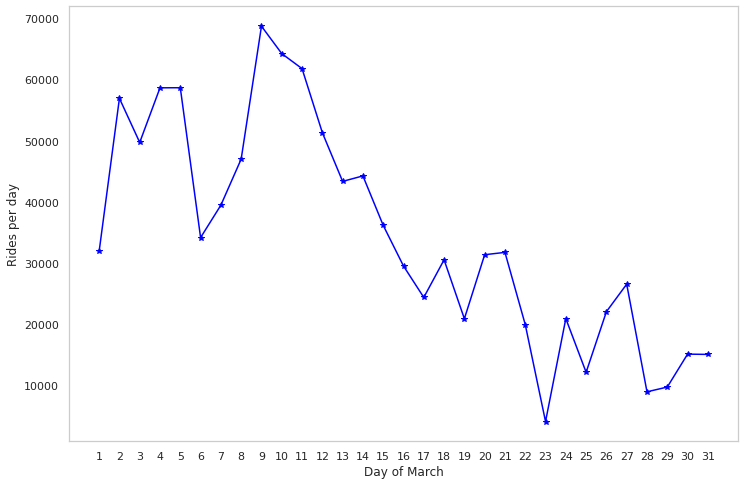

In [217]:
# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 32), rides_day, color='blue', marker='*')
_ = plt.xticks(np.arange(1, 32), np.arange(1, 32))
_ = plt.xlabel("Day of March")
_ = plt.ylabel("Rides per day")
plt.grid(False)
plt.savefig('./plots/rides_per_day.eps')

In [15]:
print("Maximum number of rides on day {}".format(np.argmax(rides_day)))
print("With {} rides".format(np.max(rides_day)))

Maximum number of rides on day 8
With 68768 rides


In [16]:
# Paramters 

ths = 3

## 2st-8th of March ##

In [17]:
# 2 -> Monday
# Choose day 
days = [2, 3, 4, 5, 6, 7, 8]
#days = [4]

# Find all connections with weights
adj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_2_6_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...
Day 7 loaded...
Day 8 loaded...


In [18]:
print("Total number of rides : {}".format(np.sum(adj_2_6_tot) / 2))

Total number of rides : 344602.0


In [19]:
adj_2_6 = adj_2_6_tot.copy()
adj_2_6[adj_2_6 < ths] = 0
adj_2_6[adj_2_6 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_2_6) / 2))

for i in range(n_tot_station):
    adj_2_6[i, i] = 0

Unweighted number of rides (edges) : 31648.5


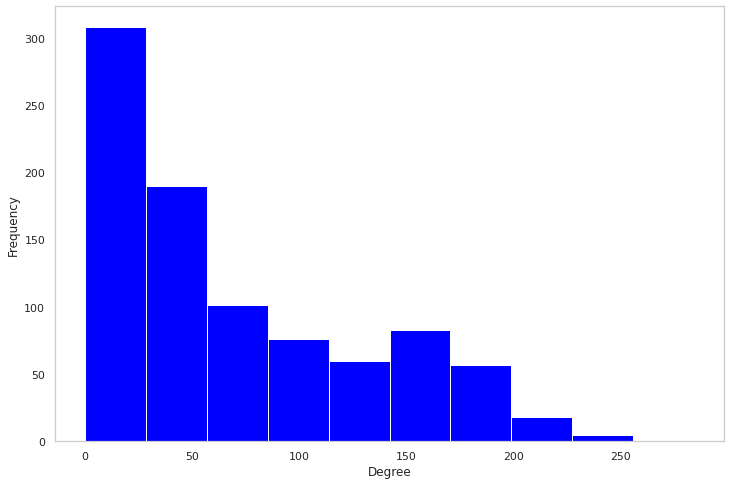

In [181]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_2_6 = nx.from_numpy_matrix(adj_2_6)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_2_6 = np.array([x[1] for x in g_2_6.degree])
_ = plt.hist(degs_2_6, color='blue')
plt.savefig('./plots/degree_2_8.eps')

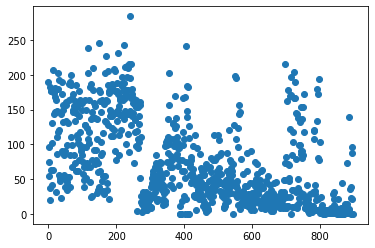

In [21]:
plt.scatter(np.arange(n_tot_station), degs_2_6)

## Plot ##

In [22]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

mplleaflet.show()

### Clustering ###

In [23]:
isolated_nodes_2_6 = []
for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        isolated_nodes_2_6.append(e.pop())

g_2_6.remove_nodes_from(isolated_nodes_2_6)

for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        print(e)

In [24]:
G_2_6 = pygsp.graphs.Graph(nx.adjacency_matrix(g_2_6))

G_2_6.compute_laplacian()
G_2_6.compute_fourier_basis()

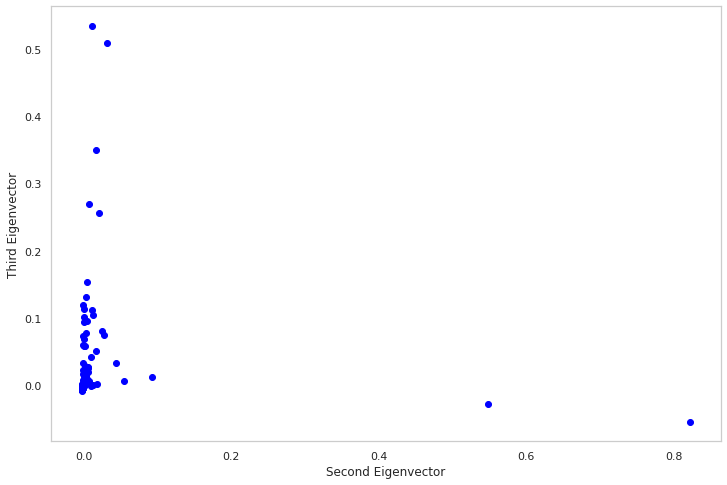

In [174]:

# Rides Per Day
plt.figure(figsize=(12,8))
plt.scatter(G_2_6.U[:,1], G_2_6.U[:,2], color='blue')
_ = plt.xlabel("Second Eigenvector")
_ = plt.ylabel("Third Eigenvector")
plt.grid(False)
plt.savefig('./plots/spectral_2_8.eps')

In [26]:
nx.write_gexf(g_2_6, "./graphs/g_2_6.gexf")

In [27]:
nx.algorithms.cluster.average_clustering(g_2_6)

0.44213059411171446

## 9th-15th of March ##

In [28]:
# 9 -> Monday
# Choose day 
days = [9, 10, 11, 12, 13, 14, 15]
#days = [11]

# Find all connections with weights
adj_9_13_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_9_13_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_9_13_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 9 loaded...
Day 10 loaded...
Day 11 loaded...
Day 12 loaded...
Day 13 loaded...
Day 14 loaded...
Day 15 loaded...


In [29]:
print("Total number of rides : {}".format(np.sum(adj_9_13_tot) / 2))

Total number of rides : 369915.0


In [30]:
adj_9_13 = adj_9_13_tot.copy()
adj_9_13[adj_9_13 < ths] = 0
adj_9_13[adj_9_13 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_9_13) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_9_13[i, i] = 0

Unweighted number of rides : 36004.0


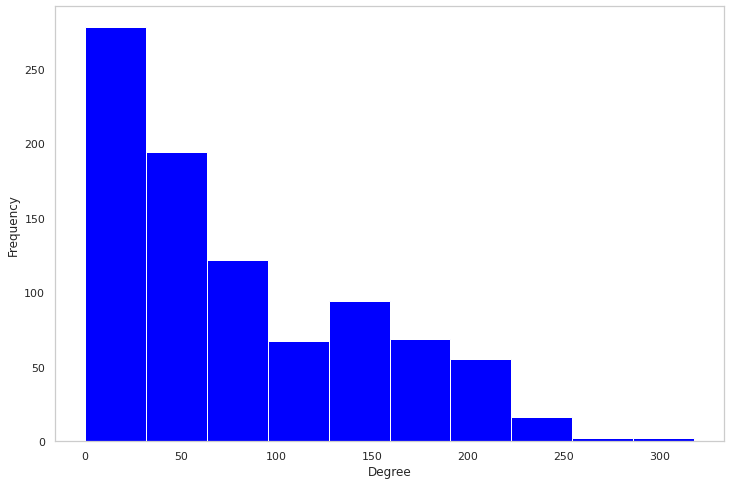

In [182]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_9_13 = nx.from_numpy_matrix(adj_9_13)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_9_13 = np.array([x[1] for x in g_9_13.degree])
_ = plt.hist(degs_9_13, color='blue')
plt.savefig('./plots/degree_9_15.eps')

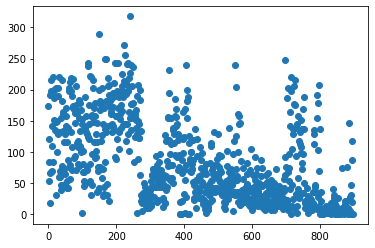

In [32]:
plt.scatter(np.arange(n_tot_station), degs_9_13)

## Plot ##

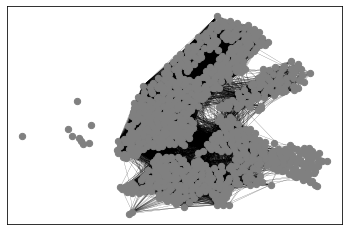

In [33]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [34]:
isolated_nodes_9_13 = []
for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        isolated_nodes_9_13.append(e.pop())

g_9_13.remove_nodes_from(isolated_nodes_9_13)

for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        print(e)

In [35]:
G_9_13 = pygsp.graphs.Graph(nx.adjacency_matrix(g_9_13))

G_9_13.compute_laplacian()
G_9_13.compute_fourier_basis()

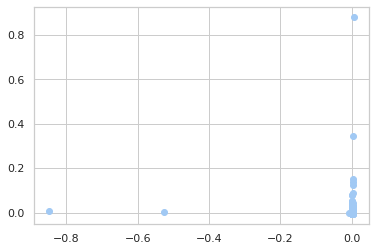

In [175]:
plt.scatter(G_9_13.U[:,1], G_9_13.U[:,2])

In [37]:
nx.algorithms.cluster.average_clustering(g_9_13)

0.4566510778708912

## 16th-22th of March ##

In [38]:
# 16 -> Monday
# Choose day 
days = [16, 17, 18, 19, 20, 21, 22]
#days = [18]

# Find all connections with weights
adj_16_20_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_16_20_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_16_20_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 16 loaded...
Day 17 loaded...
Day 18 loaded...
Day 19 loaded...
Day 20 loaded...
Day 21 loaded...
Day 22 loaded...


In [39]:
print("Total number of rides : {}".format(np.sum(adj_16_20_tot) / 2))

Total number of rides : 188080.0


In [40]:
adj_16_20 = adj_16_20_tot.copy()
adj_16_20[adj_16_20 < ths] = 0
adj_16_20[adj_16_20 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_16_20) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_16_20[i, i] = 0

Unweighted number of rides : 20604.5


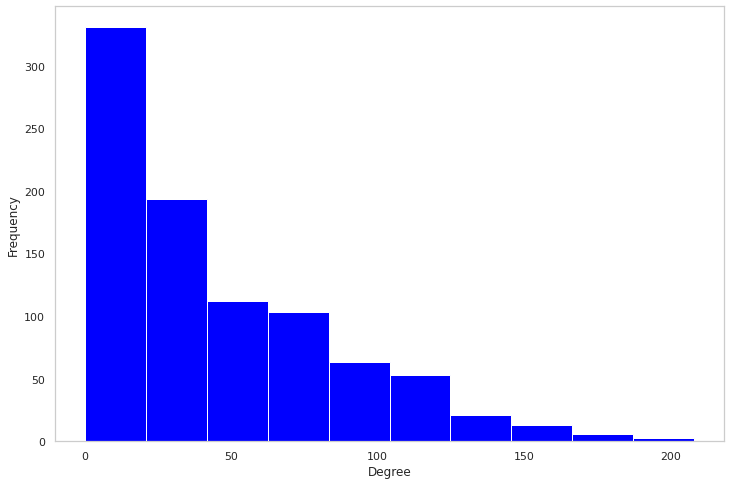

In [183]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_16_20 = nx.from_numpy_matrix(adj_16_20)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_16_20 = np.array([x[1] for x in g_16_20.degree])
_ = plt.hist(degs_16_20, color='blue')
plt.savefig('./plots/degree_16_22.eps')

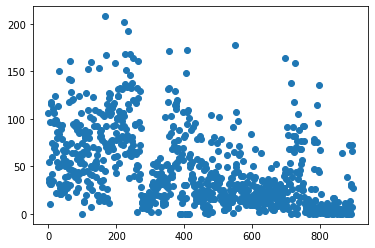

In [42]:
plt.scatter(np.arange(n_tot_station), degs_16_20)

## Plot ## 

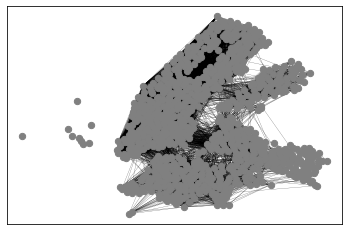

In [43]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [44]:
isolated_nodes_16_20 = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20.append(e.pop())

g_16_20.remove_nodes_from(isolated_nodes_16_20)

for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

{811}
{869}
{870}
{879}


In [45]:
isolated_nodes_16_20_ = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20_.append(e.pop())
g_16_20.remove_nodes_from(isolated_nodes_16_20_)

In [46]:
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [47]:
isolated_nodes_16_20.extend(isolated_nodes_16_20_)

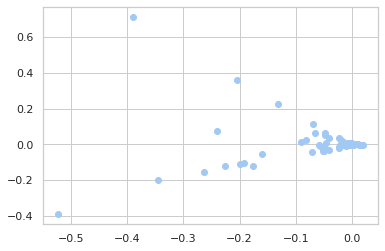

In [176]:
G_16_20 = pygsp.graphs.Graph(nx.adjacency_matrix(g_16_20))

G_16_20.compute_laplacian()
G_16_20.compute_fourier_basis()

plt.scatter(G_16_20.U[:,1], G_16_20.U[:,2])

In [49]:
nx.algorithms.cluster.average_clustering(g_16_20)

0.352592474866824

## 23st-29th of March ##

In [50]:
# 23 -> Monday
# Choose day 
days = [23, 24, 25, 26, 27, 28, 29]
#days = [24]

# Find all connections with weights
adj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_23_27_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...
Day 28 loaded...
Day 29 loaded...


In [51]:
print("Total number of rides : {}".format(np.sum(adj_23_27_tot) / 2))

Total number of rides : 103945.0


In [52]:
adj_23_27 = adj_23_27_tot.copy()
adj_23_27[adj_23_27 < ths] = 0
adj_23_27[adj_23_27 >= ths] = 1
print("Unweighted number of rides : {}".format(np.sum(adj_23_27) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_23_27[i, i] = 0

Unweighted number of rides : 11064.5


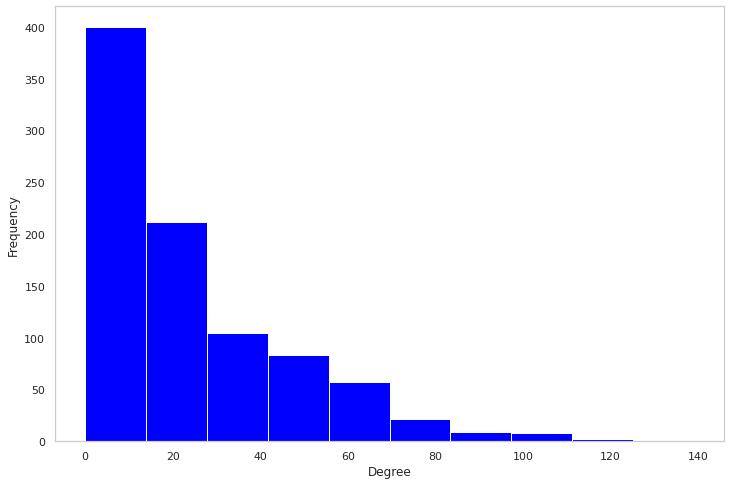

In [184]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_23_27 = nx.from_numpy_matrix(adj_23_27)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_23_27 = np.array([x[1] for x in g_23_27.degree])
_ = plt.hist(degs_23_27, color='blue')
plt.savefig('./plots/degree_23_29.eps')

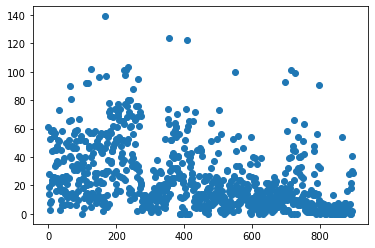

In [54]:
plt.scatter(np.arange(n_tot_station), degs_23_27)

## Plot ##

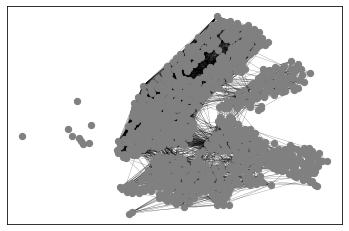

In [55]:
fig, ax = plt.subplots()

nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color='gray', ax=ax)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black', ax=ax)

# mplleaflet.show()

### Clustering ###

In [56]:
isolated_nodes_23_27 = []
for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        isolated_nodes_23_27.append(e.pop())

g_23_27.remove_nodes_from(isolated_nodes_23_27)

for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        print(e)

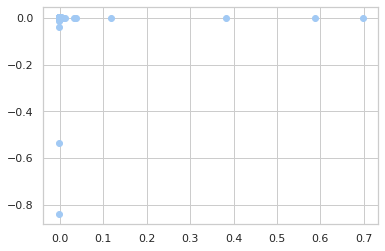

In [177]:
G_23_27 = pygsp.graphs.Graph(nx.adjacency_matrix(g_23_27))

G_23_27.compute_laplacian()
G_23_27.compute_fourier_basis()

plt.scatter(G_23_27.U[:,1], G_23_27.U[:,2])

In [58]:
nx.algorithms.cluster.average_clustering(g_23_27)

0.2437131635468674

## Deg-Sorted Nodes over time ##

In [59]:
sort_deg = np.argsort(degs_2_6)

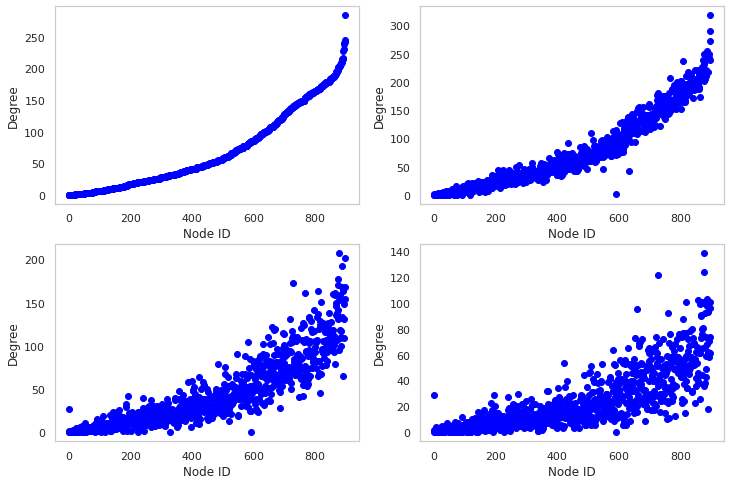

In [196]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.scatter(np.arange(n_tot_station), degs_2_6[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,2)
plt.scatter(np.arange(n_tot_station), degs_9_13[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,3)
plt.scatter(np.arange(n_tot_station), degs_16_20[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.subplot(2,2,4)
plt.scatter(np.arange(n_tot_station), degs_23_27[sort_deg], color='blue')
plt.xlabel('Node ID')
plt.ylabel('Degree')
plt.grid(False)

plt.savefig('./plots/degree_order.eps')

# Functions on Graphs #

In [272]:
f_2_6 = np.sum(adj_2_6_tot, axis=0)
f_9_13 = np.sum(adj_9_13_tot, axis=0)
f_16_20 = np.sum(adj_16_20_tot, axis=0)
f_23_27 = np.sum(adj_23_27_tot, axis=0)


In [273]:
d_2_6 = np.delete(degs_2_6, isolated_nodes_2_6)
d_9_13 = np.delete(degs_9_13, isolated_nodes_9_13)
d_16_20 = np.delete(degs_16_20, isolated_nodes_16_20)
d_23_27 = np.delete(degs_23_27, isolated_nodes_23_27)

In [274]:
cmap = plt.cm.get_cmap('hot')

In [275]:
print(np.max(f_2_6))
print(np.max(f_9_13))
print(np.max(f_16_20))
print(np.max(f_23_27))

print(np.min(f_2_6))
print(np.min(f_9_13))
print(np.min(f_16_20))
print(np.min(f_23_27))

5515.0
5329.0
2675.0
1490.0
11.0
9.0
10.0
7.0


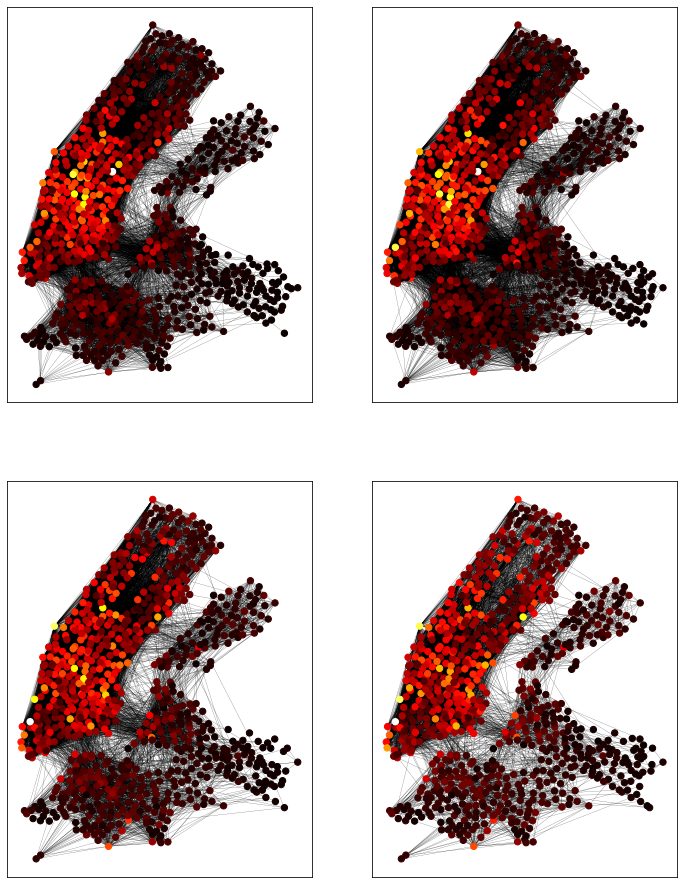

In [78]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=f_2_6, cmap=cmap, )
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=f_9_13, cmap=cmap)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=f_16_20, cmap=cmap)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=f_23_27, cmap=cmap)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')



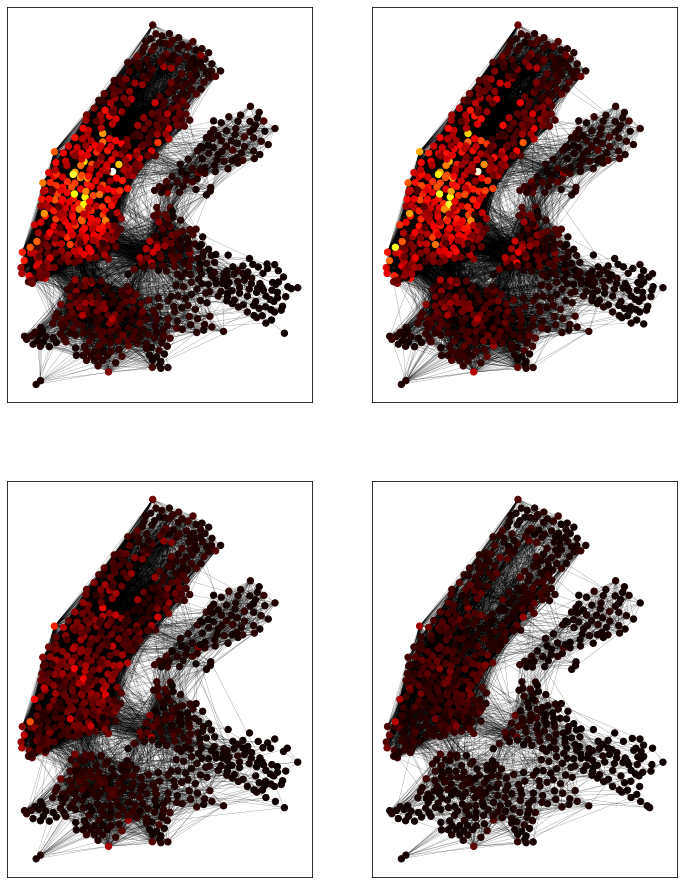

In [79]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=f_2_6, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=f_9_13, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=f_16_20, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=f_23_27, cmap=cmap, vmin=7, vmax=5515)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')



In [80]:
print(np.max(d_2_6))
print(np.max(d_9_13))
print(np.max(d_16_20))
print(np.max(d_23_27))

print(np.min(d_2_6))
print(np.min(d_9_13))
print(np.min(d_16_20))
print(np.min(d_23_27))

284
318
208
139
1
1
1
1


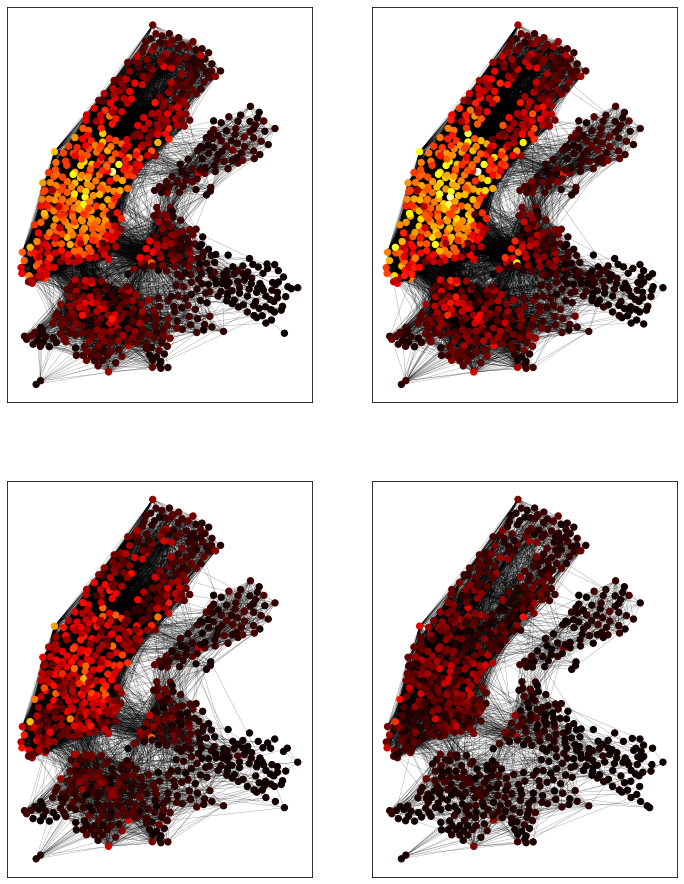

In [81]:
plt.figure(figsize=(12,16))
plt.subplot(2,2,1)

nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=d_2_6, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=d_9_13, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=d_16_20, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=d_23_27, cmap=cmap, vmin=1, vmax=318)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

# 1) Temporal Analysis # 

## Weekly days #

In [82]:
# First Week 
hour_full_2_8 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [2, 3, 4, 5, 6, 7, 8]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_2_8.extend(h_rides)
    # plt.plot(h_rides)
    j += 1
    1

In [83]:
# Second Week
hour_full_9_15 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [9, 10, 11, 12, 13, 14, 15]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_9_15.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [84]:
# Third Week
hour_full_16_22 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [16, 17, 18, 19, 20, 21, 22]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_16_22.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [85]:
# Fourth Week
hour_full_23_29 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [23, 24, 25, 26, 27, 28, 29]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1])

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_23_29.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [86]:
full_month = []
full_month.extend(hour_full_2_8)
full_month.extend(hour_full_9_15)
full_month.extend(hour_full_16_22)
full_month.extend(hour_full_23_29)

In [87]:
len(hour_full_2_8[120:])

47

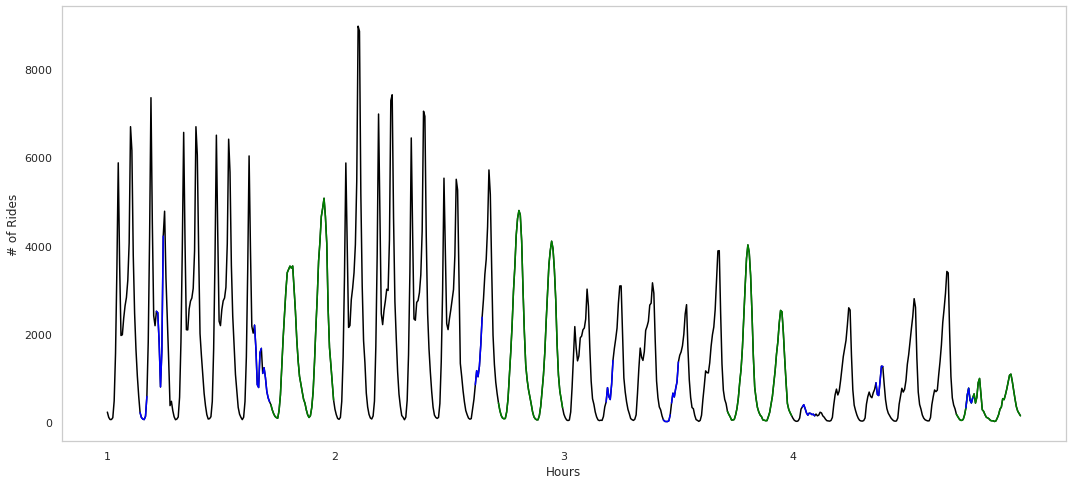

In [211]:
plt.figure(figsize=(18,8))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5))

_ = plt.xlabel('Hours')
_ = plt.ylabel('# of Rides')
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

# 3-4) Heat Maps # 

In [89]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, transform

In [90]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [91]:
%matplotlib inline

In [92]:
sf = shp.Reader("./data/shapefiles/ZIP_CODE_040114.dbf")

In [93]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [94]:
df_shape = read_shapefile(sf)

In [97]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

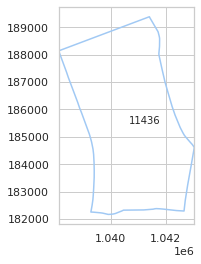

In [98]:
_ = plot_shape(0, df_shape.iloc[0]['ZIPCODE'])

In [99]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    plt.grid(False)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        """if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)"""
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

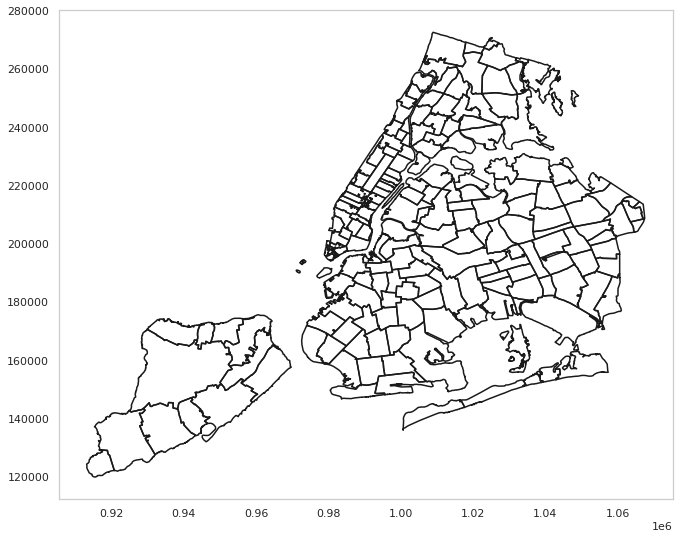

In [100]:
plot_map(sf)

In [101]:
def plot_map_fill(id, sf, x_lim = None, 
                          y_lim = None, 
                          figsize = (11,9), 
                          color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)

    fig, ax = plt.subplots(figsize = figsize)
    ax.grid(False)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.fill(x_lon,y_lat, color)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

<Figure size 792x648 with 0 Axes>

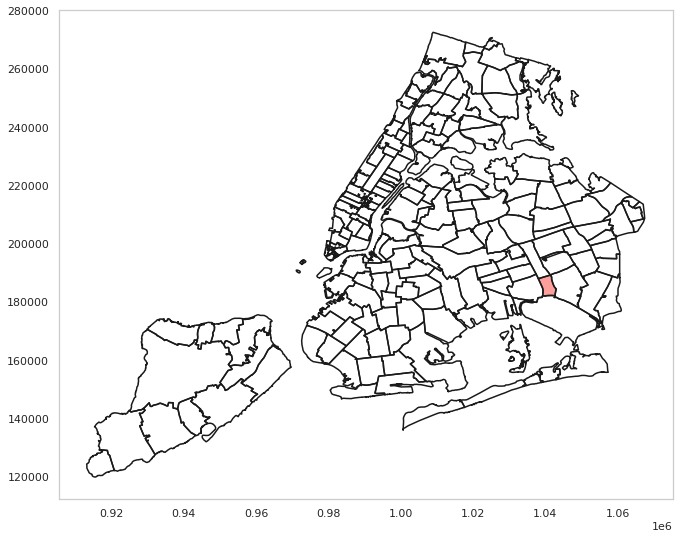

In [102]:
plot_map_fill(0, sf)

In [109]:
coo = shp.Reader('./data/shapefiles/ZIP_CODE_040114.prj')

In [110]:
td = []
days = np.arange(1, 31)
out = []
for day in days:
    ti = []
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        if row['tripduration'] < 3600:
            ti.append(row['tripduration'] )
        else:
            out.append(row['tripduration'])
    td.append(ti)

    

In [111]:
m = []
for e in td:
    e = np.array(e)
    m.append(np.mean(e))
    

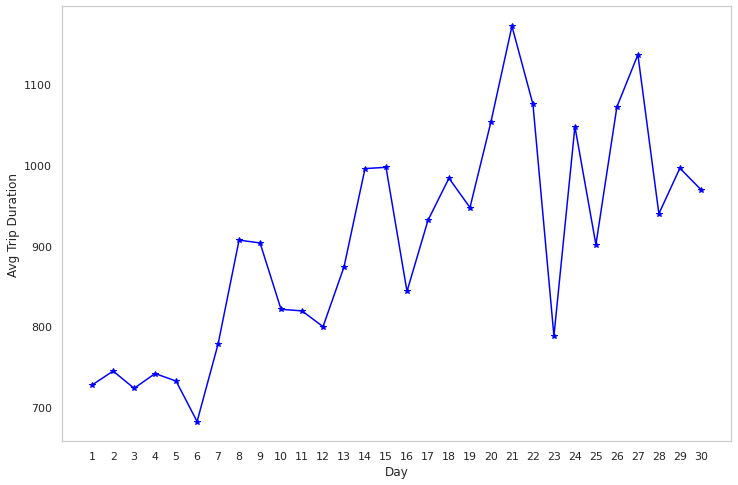

In [216]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, 31), m, color='blue', marker='*')
_ = plt.xticks(np.arange(1, 31), np.arange(1, 31))
plt.xlabel('Day')
plt.ylabel('Avg Trip Duration')
plt.grid(False)
plt.savefig('./plots/time_duration_mean.eps')

In [113]:
s = []
for e in td:
    e = np.array(e)
    s.append(np.std(e))
    

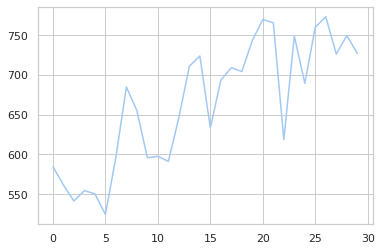

In [114]:
plt.plot(s)

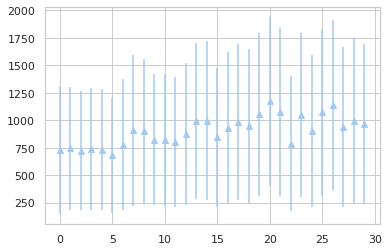

In [115]:
x = np.arange(30)

plt.errorbar(x, m, s, linestyle='None', marker='^')

plt.show()

In [116]:
first = []
for e in [2,3,4,5,6,8]:
    first.extend(td[e])
first = np.array(first)
m_f = np.mean(first)
s_f = np.std(first)

In [117]:
second = []
for e in [9, 10, 11, 12, 13, 14, 15]:
    second.extend(td[e])
second = np.array(second)
m_s = np.mean(second)
s_s = np.std(second)

In [118]:
third = []
for e in [16, 17, 18, 19, 20, 21, 22]:
    third.extend(td[e])
third = np.array(third)
m_t = np.mean(third)
s_t = np.std(third)

In [119]:
q = []
for e in [23, 24, 25, 26, 27, 28, 29] :
    q.extend(td[e])
q = np.array(q)
m_q = np.mean(q)
s_q = np.std(q)

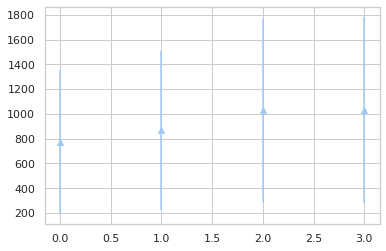

In [120]:
means = [m_f, m_s, m_t, m_q]
ss = [s_f, s_s, s_t, s_q]
x = np.arange(4)

plt.errorbar(x, means, ss, linestyle='None', marker='^')

plt.show()

In [121]:
int(280/100)

2

In [122]:
mat_time = np.zeros((36, 30))
i = 0
for e in td:
    for a in e:
        mat_time[int(a/100),i] += 1
    i += 1
    
    

In [123]:
mat_time /= np.sum(mat_time, axis=0)

mat_time = np.cumsum(mat_time, axis=0)

In [124]:
len(out)

15386

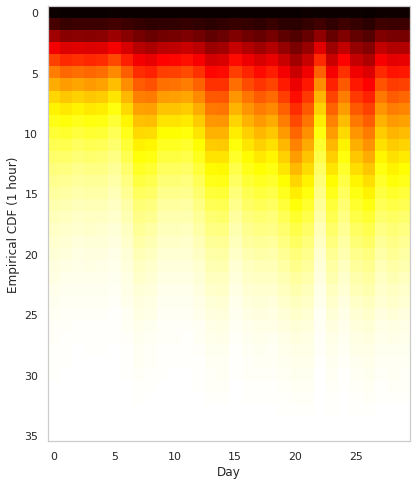

In [220]:
plt.figure(figsize=(12, 8))
plt.imshow(mat_time, cmap='hot')
plt.grid(False)
plt.xlabel('Day')
plt.ylabel('Empirical CDF (1 hour)')
plt.savefig('./plots/cdf_timeduration.eps')

# Different Graphs # 

In [126]:
ths = 1

Day 3 loaded...
Unweighted number of rides (edges) : 25858.5


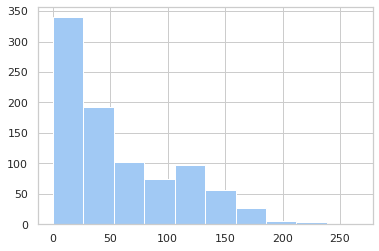

In [127]:
# Wednesday 4

days = [3]

# Find all connections with weights
adj_4_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_4_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_4_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_4 = adj_4_tot.copy()
    
adj_4[adj_4 < ths] = 0
adj_4[adj_4 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_4) / 2))

for i in range(n_tot_station):
    adj_4[i, i] = 0

# Create Undirected graph 
g_4 = nx.from_numpy_matrix(adj_4)
degs_4 = np.array([x[1] for x in g_4.degree])
_ = plt.hist(degs_4)

Day 8 loaded...
Unweighted number of rides (edges) : 24228.0


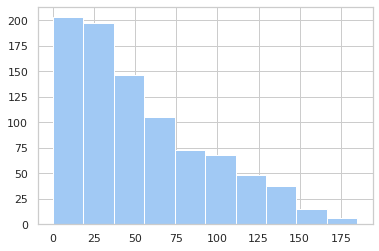

In [128]:
# Sunday 8

days = [8]

# Find all connections with weights
adj_8_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_8_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_8_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_8 = adj_8_tot.copy()
    
adj_8[adj_8 < ths] = 0
adj_8[adj_8 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_8) / 2))

for i in range(n_tot_station):
    adj_8[i, i] = 0

# Create Undirected graph 
g_8 = nx.from_numpy_matrix(adj_8)
degs_8 = np.array([x[1] for x in g_8.degree])
_ = plt.hist(degs_8)

Day 12 loaded...
Unweighted number of rides (edges) : 28021.0


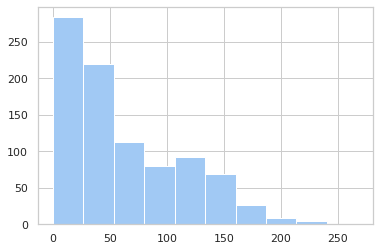

In [129]:
# Thursday 12

days = [12]

# Find all connections with weights
adj_12_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_12_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_12_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_12 = adj_12_tot.copy()
    
adj_12[adj_12 < ths] = 0
adj_12[adj_12 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_12) / 2))

for i in range(n_tot_station):
    adj_12[i, i] = 0

# Create Undirected graph 
g_12 = nx.from_numpy_matrix(adj_12)
degs_12 = np.array([x[1] for x in g_12.degree])
_ = plt.hist(degs_12)

Day 14 loaded...
Unweighted number of rides (edges) : 23704.5


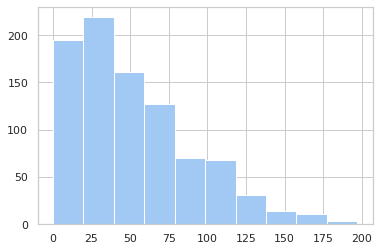

In [130]:
# Saturday 14

days = [14]

# Find all connections with weights
adj_14_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_14_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_14_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_14 = adj_14_tot.copy()
    
adj_14[adj_14 < ths] = 0
adj_14[adj_14 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_14) / 2))

for i in range(n_tot_station):
    adj_14[i, i] = 0

# Create Undirected graph 
g_14 = nx.from_numpy_matrix(adj_14)
degs_14 = np.array([x[1] for x in g_14.degree])
_ = plt.hist(degs_14)

Day 18 loaded...
Unweighted number of rides (edges) : 18562.5


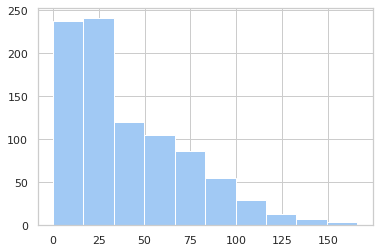

In [131]:
# Wed 18

days = [18]

# Find all connections with weights
adj_18_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_18_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_18_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_18 = adj_18_tot.copy()
    
adj_18[adj_18 < ths] = 0
adj_18[adj_18 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_18) / 2))

for i in range(n_tot_station):
    adj_18[i, i] = 0

# Create Undirected graph 
g_18 = nx.from_numpy_matrix(adj_18)
degs_18 = np.array([x[1] for x in g_18.degree])
_ = plt.hist(degs_18)

Day 21 loaded...
Unweighted number of rides (edges) : 17952.5


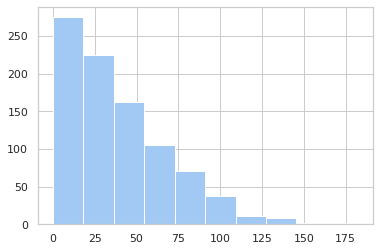

In [132]:
# Saturday 14

days = [21]

# Find all connections with weights
adj_21_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_21_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_21_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_21 = adj_21_tot.copy()
    
adj_21[adj_21 < ths] = 0
adj_21[adj_21 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_21) / 2))

for i in range(n_tot_station):
    adj_21[i, i] = 0

# Create Undirected graph 
g_21 = nx.from_numpy_matrix(adj_21)
degs_21 = np.array([x[1] for x in g_21.degree])
_ = plt.hist(degs_21)

Day 24 loaded...
Unweighted number of rides (edges) : 13160.5


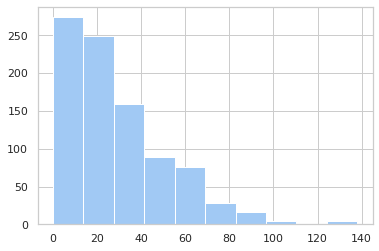

In [133]:
# Saturday 14

days = [24]

# Find all connections with weights
adj_24_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_24_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_24_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_24 = adj_24_tot.copy()
    
adj_24[adj_24 < ths] = 0
adj_24[adj_24 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_24) / 2))

for i in range(n_tot_station):
    adj_24[i, i] = 0

# Create Undirected graph 
g_24 = nx.from_numpy_matrix(adj_24)
degs_24 = np.array([x[1] for x in g_24.degree])
_ = plt.hist(degs_24)

Day 29 loaded...
Unweighted number of rides (edges) : 6697.5


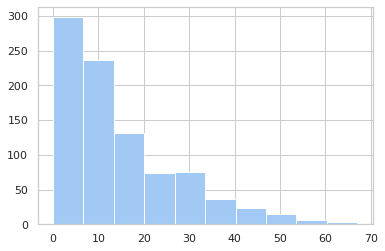

In [134]:
# Saturday 14

days = [29]

# Find all connections with weights
adj_29_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_29_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_29_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    adj_29 = adj_29_tot.copy()
    
adj_29[adj_29 < ths] = 0
adj_29[adj_29 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_29) / 2))

for i in range(n_tot_station):
    adj_29[i, i] = 0

# Create Undirected graph 
g_29 = nx.from_numpy_matrix(adj_29)
degs_29 = np.array([x[1] for x in g_29.degree])
_ = plt.hist(degs_29)

In [135]:
f_4 = np.sum(adj_4_tot, axis=0)
f_8 = np.sum(adj_8_tot, axis=0)
f_12 = np.sum(adj_12_tot, axis=0)
f_14 = np.sum(adj_14_tot, axis=0)
f_18 = np.sum(adj_18_tot, axis=0)
f_21 = np.sum(adj_21_tot, axis=0)
f_24 = np.sum(adj_24_tot, axis=0)
f_29 = np.sum(adj_29_tot, axis=0)

In [136]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
f_4[f_4 == 0] = 1

In [138]:
r_4 = f_4 / f_4
r_8 = f_8 / f_4
r_12 = f_12 / f_4
r_14 = f_14 / f_4
r_18 = f_18 / f_4
r_21 = f_21 / f_4
r_24 = f_24 / f_4
r_29 = f_29 / f_4

In [139]:
print(np.max(r_4))
print(np.max(r_8))
print(np.max(r_12))
print(np.max(r_14))
print(np.max(r_18))
print(np.max(r_21))
print(np.max(r_24))
print(np.max(r_29))

1.0
17.22222222222222
18.0
18.0
12.0
144.0
47.0
25.0


In [242]:
cmap = plt.cm.get_cmap('jet')

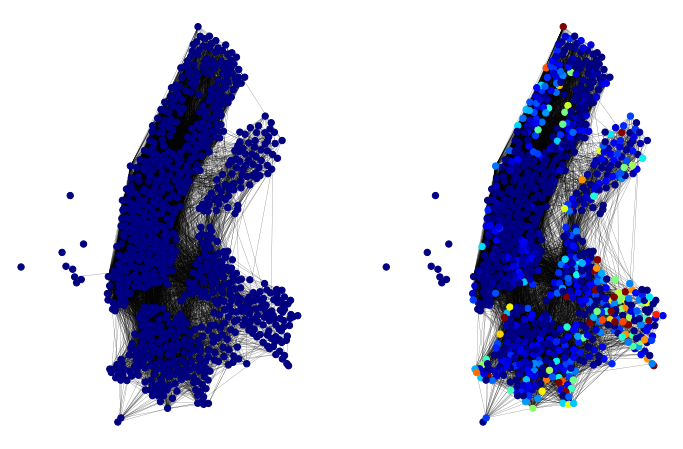

In [253]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=r_4, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/2_8_graph_1_5.jpeg')

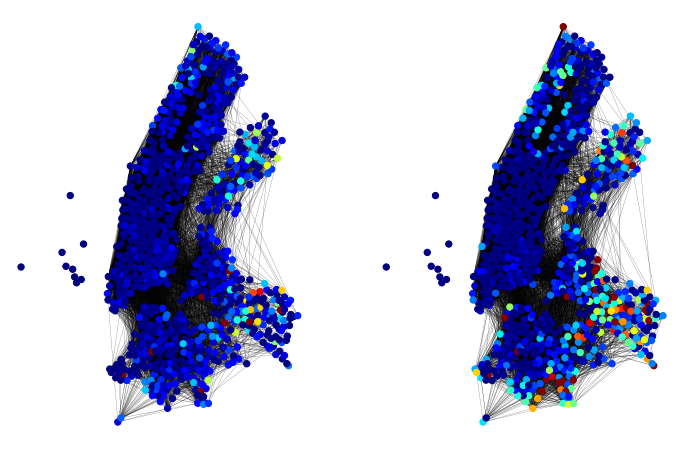

In [254]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_12, locations, node_size=40, node_color=r_12, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_12, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_14, locations, node_size=40, node_color=r_14, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_14, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/9_15_graph_1_5.jpeg')

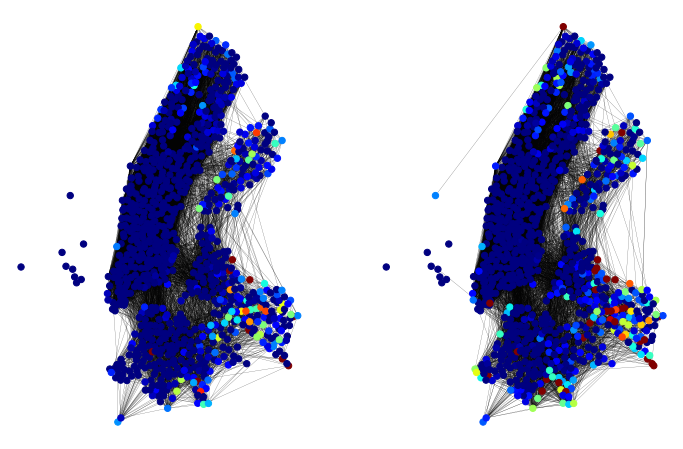

In [255]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=r_18, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_21, locations, node_size=40, node_color=r_21, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_21, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/16_22_graph_1_5.jpeg')

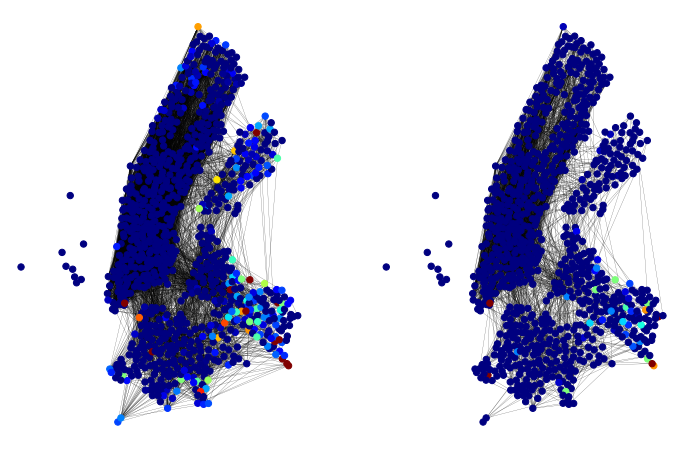

In [256]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=r_24, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=1, vmax=5)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/23_29_graph_1_5.jpeg')

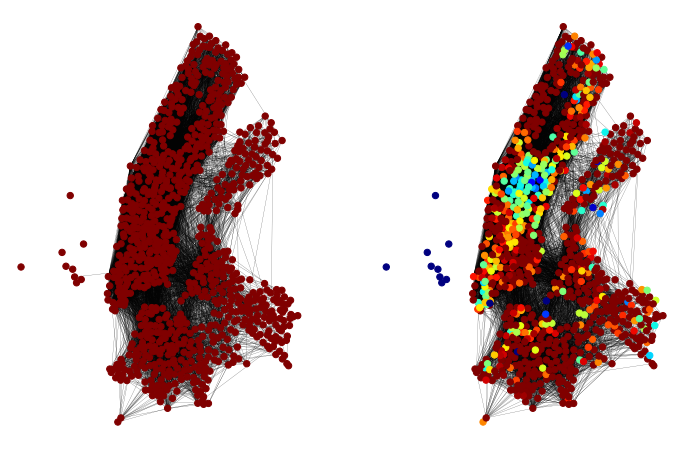

In [257]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=r_4, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/2_8_graph_0_1.jpeg')

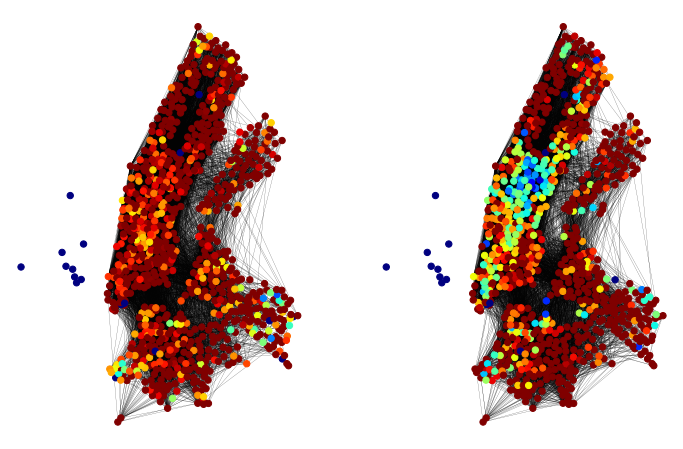

In [258]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_12, locations, node_size=40, node_color=r_12, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_12, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_14, locations, node_size=40, node_color=r_14, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_14, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/9_15_graph_0_1.jpeg')

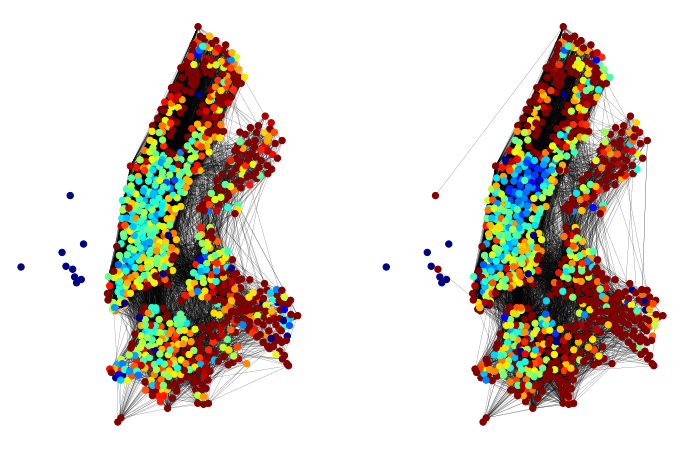

In [259]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=r_18, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_21, locations, node_size=40, node_color=r_21, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_21, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/16_22_graph_0_1.jpeg')

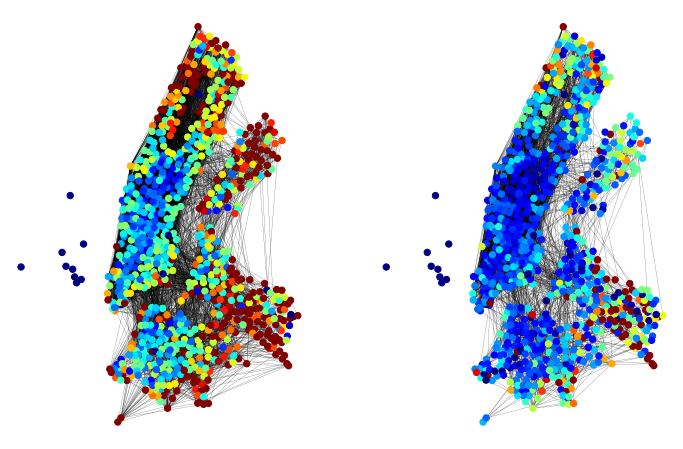

In [260]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=r_24, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')

_ = plt.savefig('./plots/23_29_graph_0_1.jpeg')

In [143]:
l = [len(e) for k,e in hour_rides(d[3], d[4]).items()]

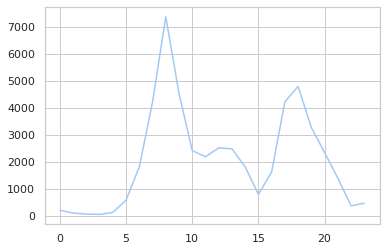

In [144]:
plt.plot(l)

Unweighted number of rides (edges) : 9223.5
Unweighted number of rides (edges) : 11883.0


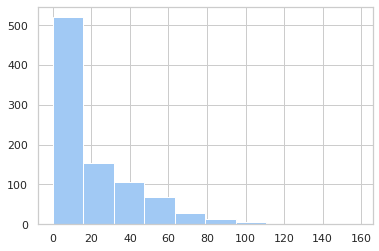

In [145]:
# Rush Hour Graph 8

# Tuesday 3

ths = 1
rides_3 = hour_rides(d[3], d[4])
rush_3_rides = rides_3[8]
rush_3_rides.extend(rides_3[9])

# Find all connections with weights
adj_3_rush_tot = np.zeros((n_tot_station, n_tot_station))
for index, row in df.iloc[rush_3_rides[0]:rush_3_rides[-1]].iterrows():
    adj_3_rush_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    adj_3_rush_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1

adj_3_rush = adj_3_rush_tot.copy()
    
adj_3_rush[adj_3_rush < ths] = 0
adj_3_rush[adj_3_rush >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_rush) / 2))
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_rush_tot) / 2))

for i in range(n_tot_station):
    adj_3_rush[i, i] = 0

# Create Undirected graph 
g_3_rush = nx.from_numpy_matrix(adj_3_rush)
degs_3_rush = np.array([x[1] for x in g_3_rush.degree])
_ = plt.hist(degs_3_rush)

Unweighted number of rides (edges) : 4117.5
Unweighted number of rides (edges) : 4992.0


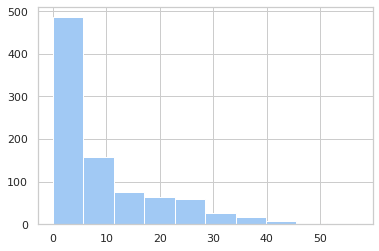

In [147]:
# Rush Hour Graph 8

# Wednesday 4

ths = 1
rides_3 = hour_rides(d[3], d[4])
calm_3_rides = rides_3[12]
calm_3_rides.extend(rides_3[13])

# Find all connections with weights
adj_3_calm_tot = np.zeros((n_tot_station, n_tot_station))
for index, row in df.iloc[calm_3_rides[0]:calm_3_rides[-1]].iterrows():
    adj_3_calm_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    adj_3_calm_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1

adj_3_calm = adj_3_calm_tot.copy()
    
adj_3_calm[adj_3_calm < ths] = 0
adj_3_calm[adj_3_calm >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_calm) / 2))
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_3_calm_tot) / 2))

for i in range(n_tot_station):
    adj_3_calm[i, i] = 0

# Create Undirected graph 
g_3_calm = nx.from_numpy_matrix(adj_3_calm)
degs_3_calm = np.array([x[1] for x in g_3_calm.degree])
_ = plt.hist(degs_3_calm)

In [148]:
f_3_rush = np.sum(adj_3_rush_tot, axis=0)
f_3_calm = np.sum(adj_3_calm_tot, axis=0)

In [149]:
print(np.max(f_3_rush))
print(np.max(f_3_calm))

print(np.min(f_3_rush))
print(np.min(f_3_calm))

331.0
87.0
0.0
0.0


In [150]:
r_calm = f_3_calm / f_3_rush

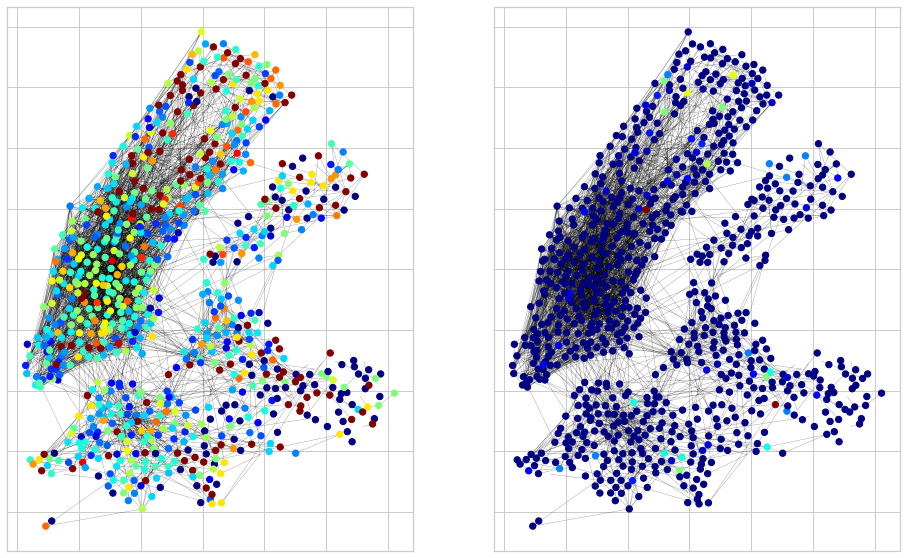

In [151]:
plt.figure(figsize=(16, 10))

plt.subplot(1,2,1)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap,  vmin=1, vmax=5)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')


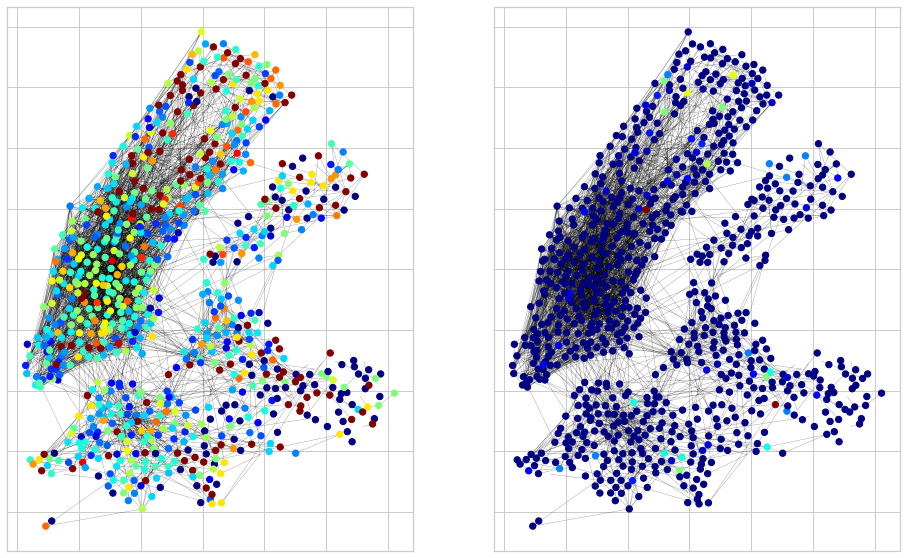

In [152]:
plt.figure(figsize=(16, 10))

plt.subplot(1,2,1)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
nx.draw_networkx_nodes(g_3_calm, locations, node_size=40, node_color=r_calm, cmap=cmap,  vmin=1, vmax=5)
nx.draw_networkx_edges(g_3_calm, locations, alpha=0.8, width=0.2, edge_color='black')


In [286]:
from pygsp.filters import Heat

In [343]:
source_node = 1

In [344]:
t = np.arange(0, 100)

h = Heat(G_2_6, tau=t)

source = np.zeros(G_2_6.U.shape[0])
source[source_node] = 100

y_2_6 = h.filter(source)


In [345]:
for e in isolated_nodes_2_6:
    y_2_6 = np.insert(y_2_6, e, 0, axis=0)

In [346]:
t = np.arange(0, 100)

h = Heat(G_23_27, tau=t)

source = np.zeros(G_23_27.U.shape[0])
source[source_node] = 100

y_23_27 = h.filter(source)

In [347]:
for e in isolated_nodes_23_27:
    y_23_27 = np.insert(y_23_27, e, 0, axis=0)

In [348]:
hotmap = plt.cm.get_cmap('hot')

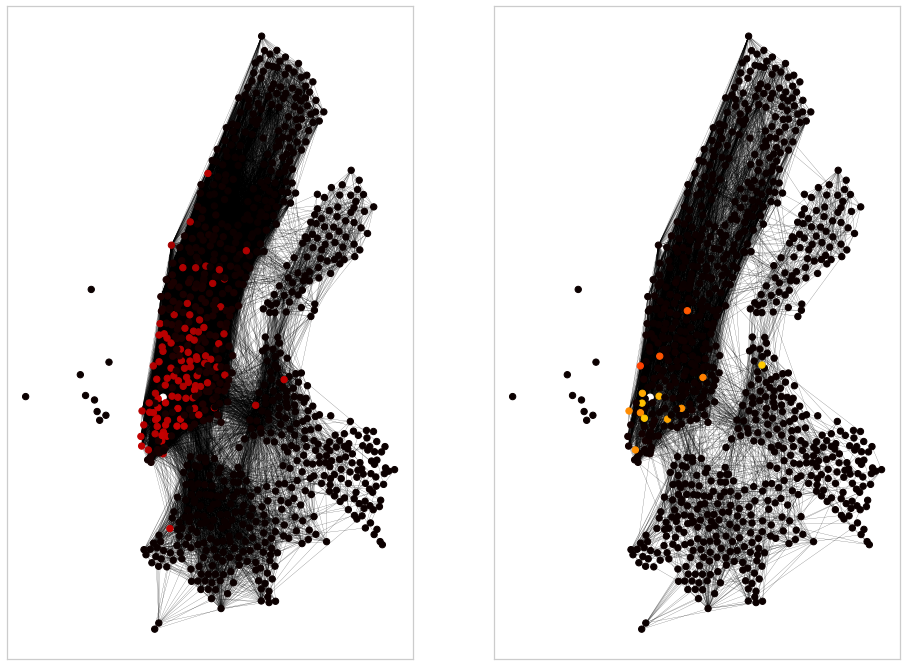

In [350]:
plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.grid(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=y_2_6[:,1], cmap=hotmap, vim=0, vmax=1)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
plt.grid(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=y_23_27[:,1], cmap=hotmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

In [ ]:
plt.plot(y_2_6[:,1])

In [ ]:
y_23_27[241,1] = 1

In [ ]:
plt.plot(y_23_27[:,1])